In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [3]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [4]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())
alph_len = len(new_alph)

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)
train_data_f = np.reshape(train_data, (-1, alph_len * seq_len))
#val_data_f = np.reshape(val_data, (-1, alph_len * seq_len))
test_data_f = np.reshape(test_data, (-1, alph_len * seq_len))

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:
from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [6]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD

# need to reshape data for 1d conv
num_features = seq_len
num_channels = len(new_alph)
train_data = train_data.reshape(train_data.shape[0], num_features, num_channels).astype('float32')
test_data = test_data.reshape(test_data.shape[0], num_features, num_channels).astype('float32') 

from keras.layers import Conv1D, MaxPooling1D
def conv1d(kernel_width, num_filters, hidden_layers,num_features = 23, num_channels = 10): 
    # already flattened b/c one_hot encoded
    X_in = Input(shape=(num_features,num_channels),dtype='float32')
    conv = Conv1D(filters=num_filters, kernel_size=kernel_width, padding='same')(X_in)
    #pool = MaxPooling1D(pool_size=2)(conv)
    H = Flatten()(conv)#(pool)
    for h in hidden_layers: 
        H = Dense(h, activation='relu')(H)
    out = Dense(2,activation="softmax")(H)
    model = Model(inputs=[X_in], outputs=out)
    #model.summary()
    #crossentropy is for probabilities
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define k-fold cross validation test harness
num_folds = 3
num_epochs = 20
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
all_scores = {}
X = train_data
y = train_bins

kernel_widths = [3,5]
num_filters = [5,10,20]
hidden_layer_choices = [(150,50,10), (150,50),(100,30), (100,),(30,)]

for hidden_layers in hidden_layer_choices: 
    for kernel_width in kernel_widths: 
        for num_filt in num_filters:
            param_combo = (hidden_layers,kernel_width,num_filt)
            cvscores = []
            for train, test in kfold.split(X, y.argmax(1)):
              # create model
                model = conv1d(kernel_width = kernel_width, num_filters = num_filt, hidden_layers=hidden_layers)
                #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
                model.fit(X[train], y[train],epochs=num_epochs, batch_size=128,verbose=0)#,callbacks=[early_stopping])
                # evaluate the model

                y_pred = model.predict(X[test])
                y_true = y[test]

                y_true_labels = np.argmax(y[test], axis=1)
                y_pred_labels = np.argmax(y_pred, axis=1) 

                average_precision = average_precision_score(y_true, y_pred)
                auc = roc_auc_score(y_true_labels, y_pred_labels)
                acc = sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels)
                f1_val = sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro')
                print('Average precision-recall score:', average_precision)
                print('AUC:', auc)
                print('Accuracy:', acc)
                print('F1:', f1_val)
                cvscores.append([average_precision, auc, acc, f1_val])
            all_scores[param_combo] = cvscores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 5)             155       
_________________________________________________________________
flatten_2 (Flatten)          (None, 115)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               17400     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 22        
Total para

Average precision-recall score: 0.8067477266941951
AUC: 0.7786441571379175
Accuracy: 0.998624168768631
F1: 0.7924731497722627
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 23, 10)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 23, 20)            620       
_________________________________________________________________
flatten_8 (Flatten)          (None, 460)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 150)               69150     
_________________________________________________________________
dense_30 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                510       
________________

Average precision-recall score: 0.7987519953463089
AUC: 0.7445347012498398
Accuracy: 0.9987067186425131
F1: 0.7840798637878692
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 23, 10)            510       
_________________________________________________________________
flatten_14 (Flatten)         (None, 230)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 150)               34650     
_________________________________________________________________
dense_54 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_55 (Dense)             (None, 10)                510       
_______________

Average precision-recall score: 0.7769003598692603
AUC: 0.8019057095119846
Accuracy: 0.9978628754872736
F1: 0.7478447115729314
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 23, 5)             155       
_________________________________________________________________
flatten_20 (Flatten)         (None, 115)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 150)               17400     
_________________________________________________________________
dense_78 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_79 (Dense)             (None, 2)                 102       
Total params: 2

Average precision-recall score: 0.8034078676570279
AUC: 0.6962523853075255
Accuracy: 0.9987709466462436
F1: 0.7637768429930272
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 23, 20)            620       
_________________________________________________________________
flatten_27 (Flatten)         (None, 460)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 150)               69150     
_________________________________________________________________
dense_99 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_100 (Dense)            (None, 2)                 102       
Total params: 7

Average precision-recall score: 0.7755657481846518
AUC: 0.72490577864518
Accuracy: 0.9985874928916039
F1: 0.7634500254696213
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 23, 10)            510       
_________________________________________________________________
flatten_34 (Flatten)         (None, 230)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 150)               34650     
_________________________________________________________________
dense_120 (Dense)            (None, 50)                7550      
_________________________________________________________________
dense_121 (Dense)            (None, 2)                 102       
Total params: 42,

Average precision-recall score: 0.7833285038134545
AUC: 0.752273238340027
Accuracy: 0.9984223801880303
F1: 0.7633411992856329
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_41 (Flatten)         (None, 230)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 100)               23100     
_________________________________________________________________
dense_141 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_142 (Dense)            (None, 2)                 62        
Total params: 26

Average precision-recall score: 0.7971394185480987
AUC: 0.670088157040739
Accuracy: 0.9987067423665698
F1: 0.7395286817967843
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 23, 5)             255       
_________________________________________________________________
flatten_48 (Flatten)         (None, 115)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 100)               11600     
_________________________________________________________________
dense_162 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_163 (Dense)            (None, 2)                 62        
Total params: 14

Average precision-recall score: 0.7916727705844138
AUC: 0.7457654930358338
Accuracy: 0.998495771650799
F1: 0.7666687894099469
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 23, 20)            1020      
_________________________________________________________________
flatten_55 (Flatten)         (None, 460)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 100)               46100     
_________________________________________________________________
dense_183 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_184 (Dense)            (None, 2)                 62        
Total params: 50

Average precision-recall score: 0.8272518420676166
AUC: 0.7590152934844666
Accuracy: 0.9988626670457776
F1: 0.8071686624151202
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 23, 20)            620       
_________________________________________________________________
flatten_63 (Flatten)         (None, 460)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 100)               46100     
_________________________________________________________________
dense_200 (Dense)            (None, 2)                 202       
Total params: 46,922
Trainable params: 46,922
Non-trainable params: 0
_________________________________________________________________
None
Averag

Average precision-recall score: 0.8025572841890762
AUC: 0.7968906335761764
Accuracy: 0.9983398303141481
F1: 0.7772254590760125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 23, 20)            1020      
_________________________________________________________________
flatten_71 (Flatten)         (None, 460)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 100)               46100     
_________________________________________________________________
dense_216 (Dense)            (None, 2)                 202       
Total params: 47,322
Trainable params: 47,322
Non-trainable params: 0
_________________________________________________________________
None
Averag

Average precision-recall score: 0.8100564718249725
AUC: 0.805814123257335
Accuracy: 0.998385706161833
F1: 0.7849615199361852
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_79 (Flatten)         (None, 230)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 30)                6930      
_________________________________________________________________
dense_232 (Dense)            (None, 2)                 62        
Total params: 7,302
Trainable params: 7,302
Non-trainable params: 0
_________________________________________________________________
None
Average pr

Average precision-recall score: 0.8039300909135196
AUC: 0.6544089151668517
Accuracy: 0.9987067423665698
F1: 0.7274755289080687
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 23, 10)            510       
_________________________________________________________________
flatten_87 (Flatten)         (None, 230)               0         
_________________________________________________________________
dense_247 (Dense)            (None, 30)                6930      
_________________________________________________________________
dense_248 (Dense)            (None, 2)                 62        
Total params: 7,502
Trainable params: 7,502
Non-trainable params: 0
_________________________________________________________________
None
Average 

In [10]:
d = pd.DataFrame.from_dict(all_scores)
d.to_csv('cnn_grid_search_all.csv')

In [11]:
cv_means = {k:sum(np.array(v)/num_folds) for k,v in all_scores.items()}

<BarContainer object of 30 artists>

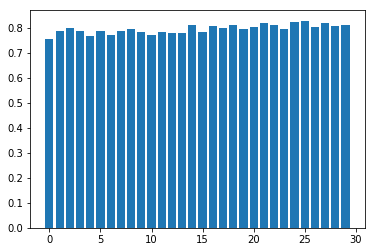

In [12]:
cv_means_df = pd.DataFrame.from_dict(cv_means)
param_combos = list(cv_means.keys())
score_vals = [cv_means[k][0] for k in param_combos]
plt.bar(range(len(param_combos)),score_vals)

In [13]:
max(score_vals)

0.8286917434207051

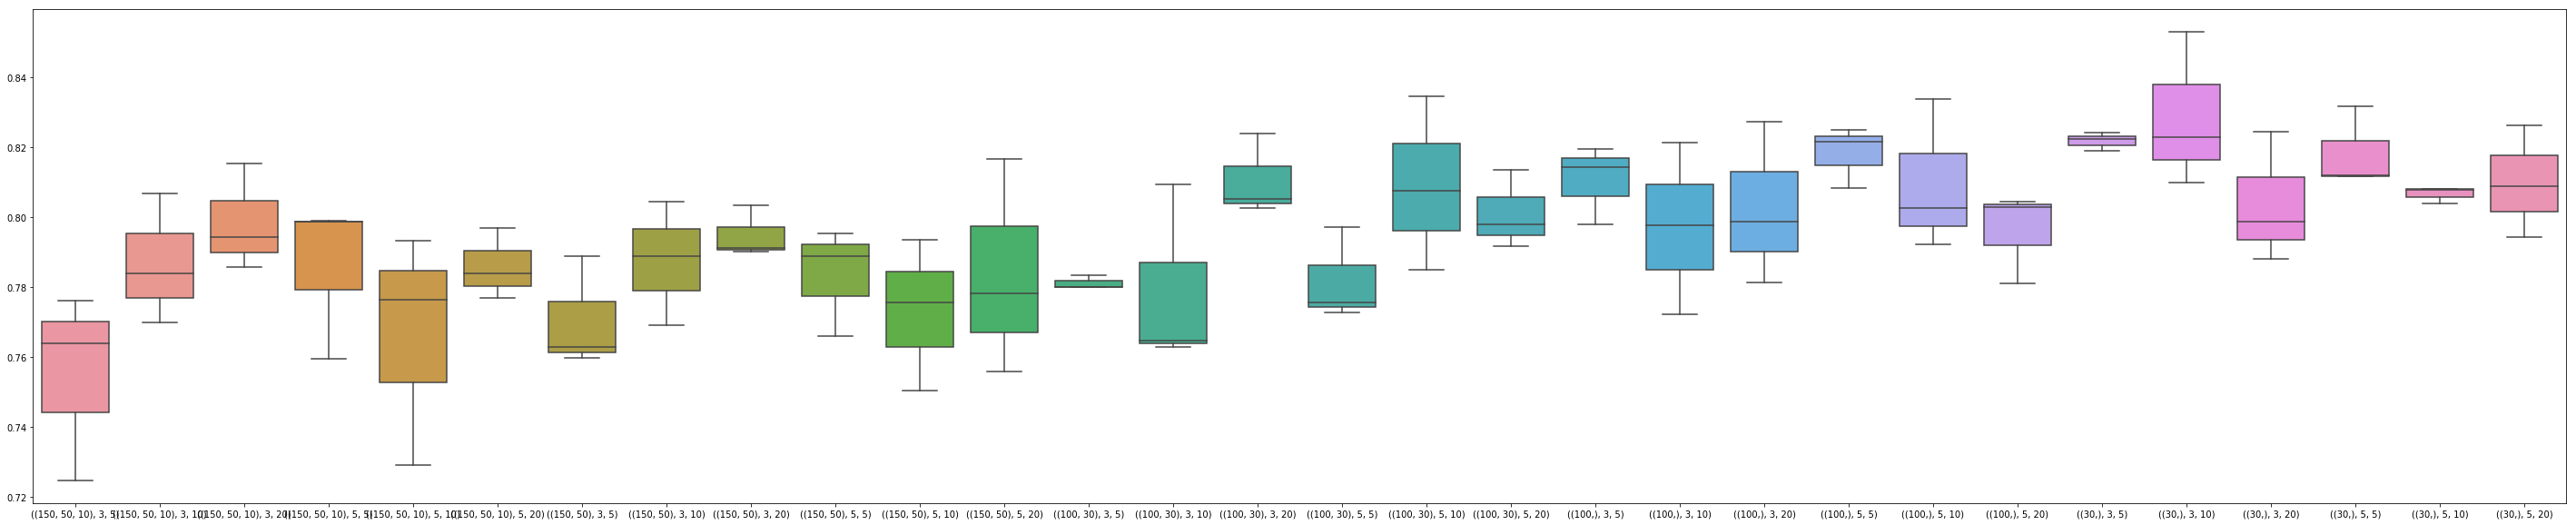

In [21]:
prec_recall_scores = []
for params in param_combos:
    folds = all_scores[params]
    prec_recall_scores.append([fold[0] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
plt.figure(figsize=(50,10))
sns.boxplot(param_combos_str, prec_recall_scores)

In [22]:
# best => kernel_width = 3, hidden_layers = (30,), # kernels = 10

In [23]:
all_scores[((30,), 3, 10)]

[[0.8530917439307213,
  0.779962295929569,
  0.9989452154053583,
  0.8249638689110694],
 [0.8100564718249725,
  0.805814123257335,
  0.998385706161833,
  0.7849615199361852],
 [0.8229270145064216,
  0.7078166369661463,
  0.9988259573492319,
  0.7759298800793263]]

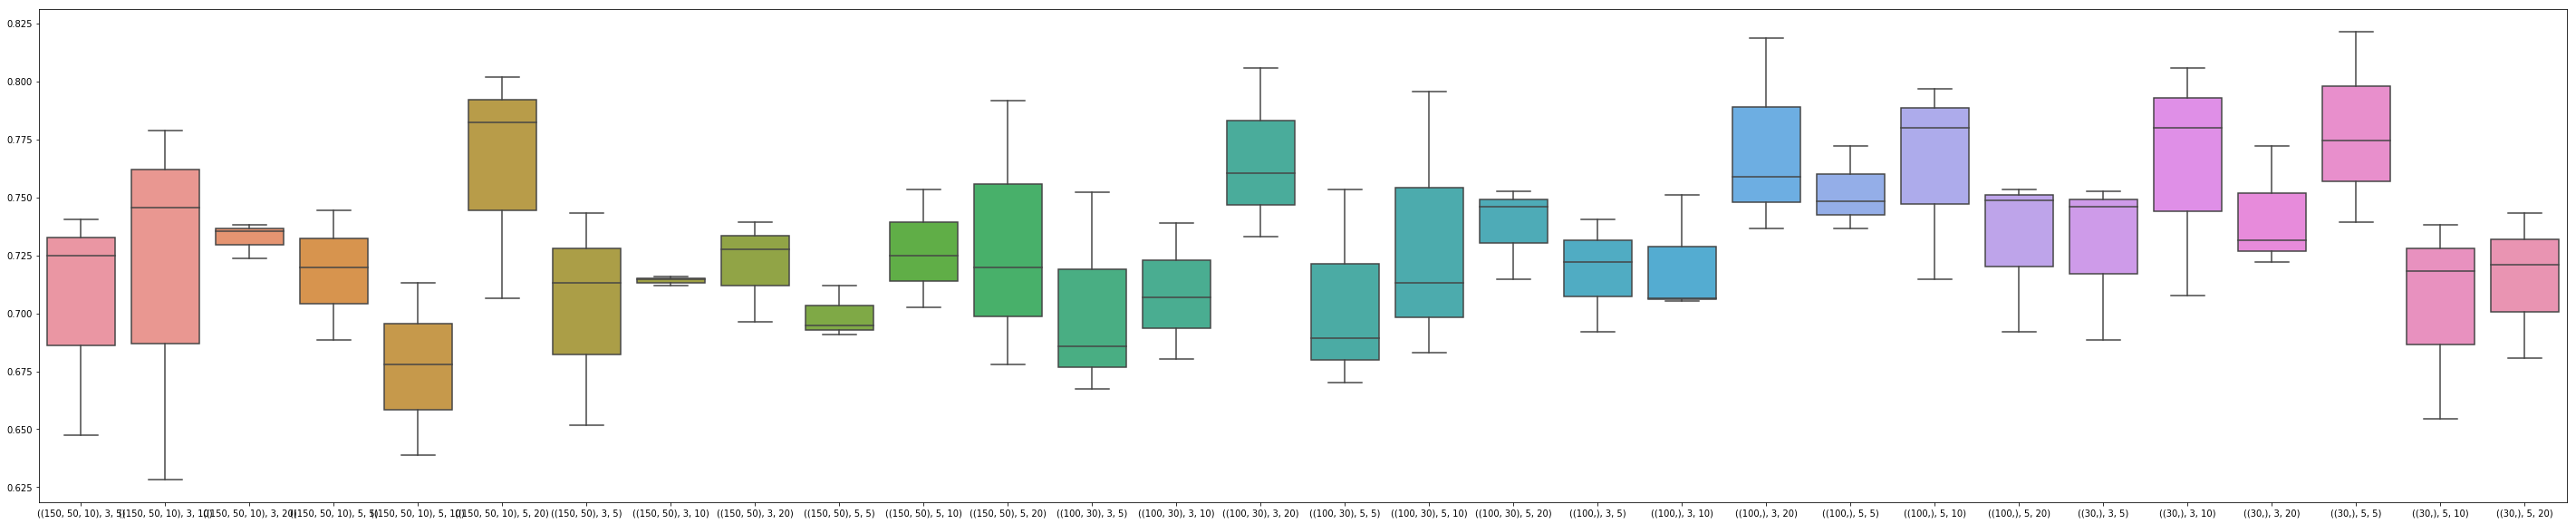

In [24]:
aucs = []
for params in param_combos:
    folds = all_scores[params]
    aucs.append([fold[1] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
plt.figure(figsize=(50,10))
sns.boxplot(param_combos_str, aucs)